In [1]:
from utils.config import CONFIG
CONFIG.PSP_USE_MEAN = True
import torch
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
from psp.pSp_pure import pSp
from utils.dataset import MulticlassImageDataset
from pathlib import Path
output_dir = Path("output/paper/soft_loss")
output_dir.mkdir(parents=True, exist_ok=True)
dataset = MulticlassImageDataset(
    ["input/data/covid_ct_pneumonia/train"],
    ["lung", "localizer", "bones", "drr", "soft"],
)
dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
)

Loading images from each class: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


In [6]:
from glob import glob
list(glob("input/data/covid_ct_pneumonia/train/lung/*.png"))[397]

'input/data/covid_ct_pneumonia/train/lung/000405.png'

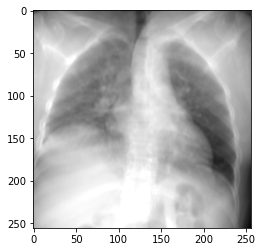

In [6]:
import matplotlib.pyplot as plt

item = dataset[0]["lung"].numpy()[0]
plt.imshow(item, cmap="gray")

In [2]:
ckpt0 = torch.load("output/psp_pure_pneumonia_chosen/checkpoint/140000.pt", map_location="cuda:0")
net0 = pSp(ckpt0).to("cuda:0")
net0.latent_avg = net0.latent_avg.to("cuda:0") if net0.latent_avg is not None else None
net0.eval();
ckpt1 = torch.load("output/psp_pure_pneumonia_chosen_soft/checkpoint/160000.pt", map_location="cuda:1")
net1 = pSp(ckpt1).to("cuda:1")
net1.latent_avg = net1.latent_avg.to("cuda:1") if net1.latent_avg is not None else None
net1.eval();
ckpt2 = torch.load("output/psp_pure_pneumonia_chosen_soft_more_reg/checkpoint/160000.pt", map_location="cuda:2")
net2 = pSp(ckpt2).to("cuda:2")
net2.latent_avg = net2.latent_avg.to("cuda:2") if net2.latent_avg is not None else None
net2.eval();
ckpt3 = torch.load("output/psp_pure_pneumonia_chosen_softer/checkpoint/160000.pt", map_location="cuda:3")
net3 = pSp(ckpt3).to("cuda:3")
net3.latent_avg = net3.latent_avg.to("cuda:3") if net3.latent_avg is not None else None
net3.eval();

In [3]:
for idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    with torch.no_grad():
        img_in = batch["lung"].to("cuda:0")
        img_out0, _  = net0(img_in.to("cuda:0"))
        img_out1, _  = net1(img_in.to("cuda:1"))
        img_out2, _  = net2(img_in.to("cuda:2"))
        img_out3, _  = net3(img_in.to("cuda:3"))
        img_out0 = img_out0.to("cuda:0")
        img_out1 = img_out1.to("cuda:0")
        img_out2 = img_out2.to("cuda:0")
        img_out3 = img_out3.to("cuda:0")
    img = torch.concat([img_in,batch["soft"].to("cuda:0"),img_out0,img_out1,img_out2,img_out3], dim=3)
    save_image(
        img,
        str(output_dir / f"{str(idx).zfill(6)}.png"),
        nrow=1,
        normalize=True,
        value_range=(-1, 1),
    )

100%|██████████| 642/642 [02:34<00:00,  4.16it/s]
